# Document Layout Analysis

Natural PDF can automatically detect the structure of a document (titles, paragraphs, tables, figures) using layout analysis models. This guide shows how to use this feature.

## Setup

We'll use a sample PDF that includes various layout elements.

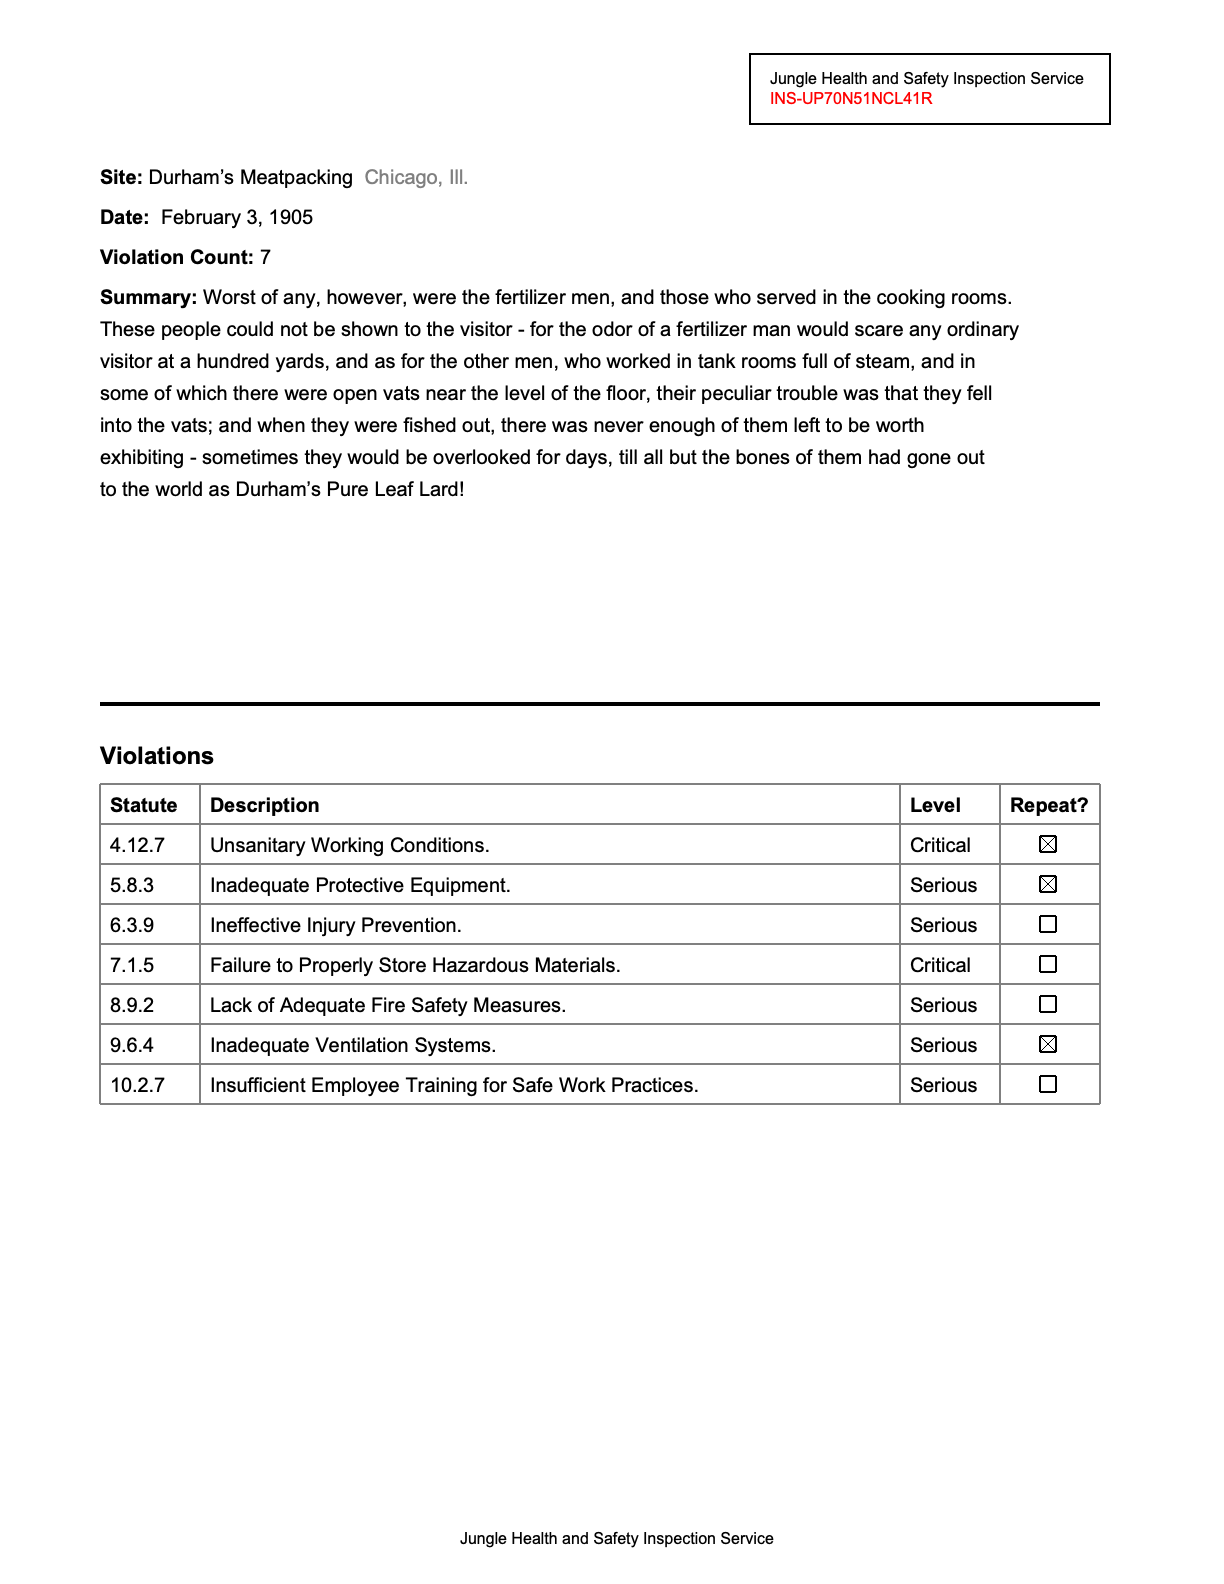

In [1]:
from natural_pdf import PDF

# Ensure layout analysis models are installed if needed:
# !pip install natural-pdf[layout_yolo]  # Default
# !pip install natural-pdf[layout_paddle] # Optional
# !pip install natural-pdf[layout_tatr]   # Optional (for tables)

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

# Display the page
page.show()

## Running Basic Layout Analysis

Use the `analyze_layout()` method. By default, it uses the YOLO model.

In [2]:
# Analyze the layout using the default engine (YOLO)
# This adds 'region' elements to the page
page.analyze_layout()

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmp9bt8cr_b/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 3078.2ms


Speed: 6.7ms preprocess, 3078.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 800)


<ElementCollection[Region](count=8)>

In [3]:
# Find all detected regions
regions = page.find_all('region')
len(regions) # Show how many regions were detected

8

In [4]:
# Each region has a 'type' attribute (e.g., 'title', 'plain-text', 'table')
# and a 'confidence' score.
if regions:
    first_region = regions[0]
    f"First region: type='{first_region.type}', confidence={first_region.confidence:.2f}"

## Visualizing Detected Layout

Use `highlight_all()` or `show()` on the detected regions.

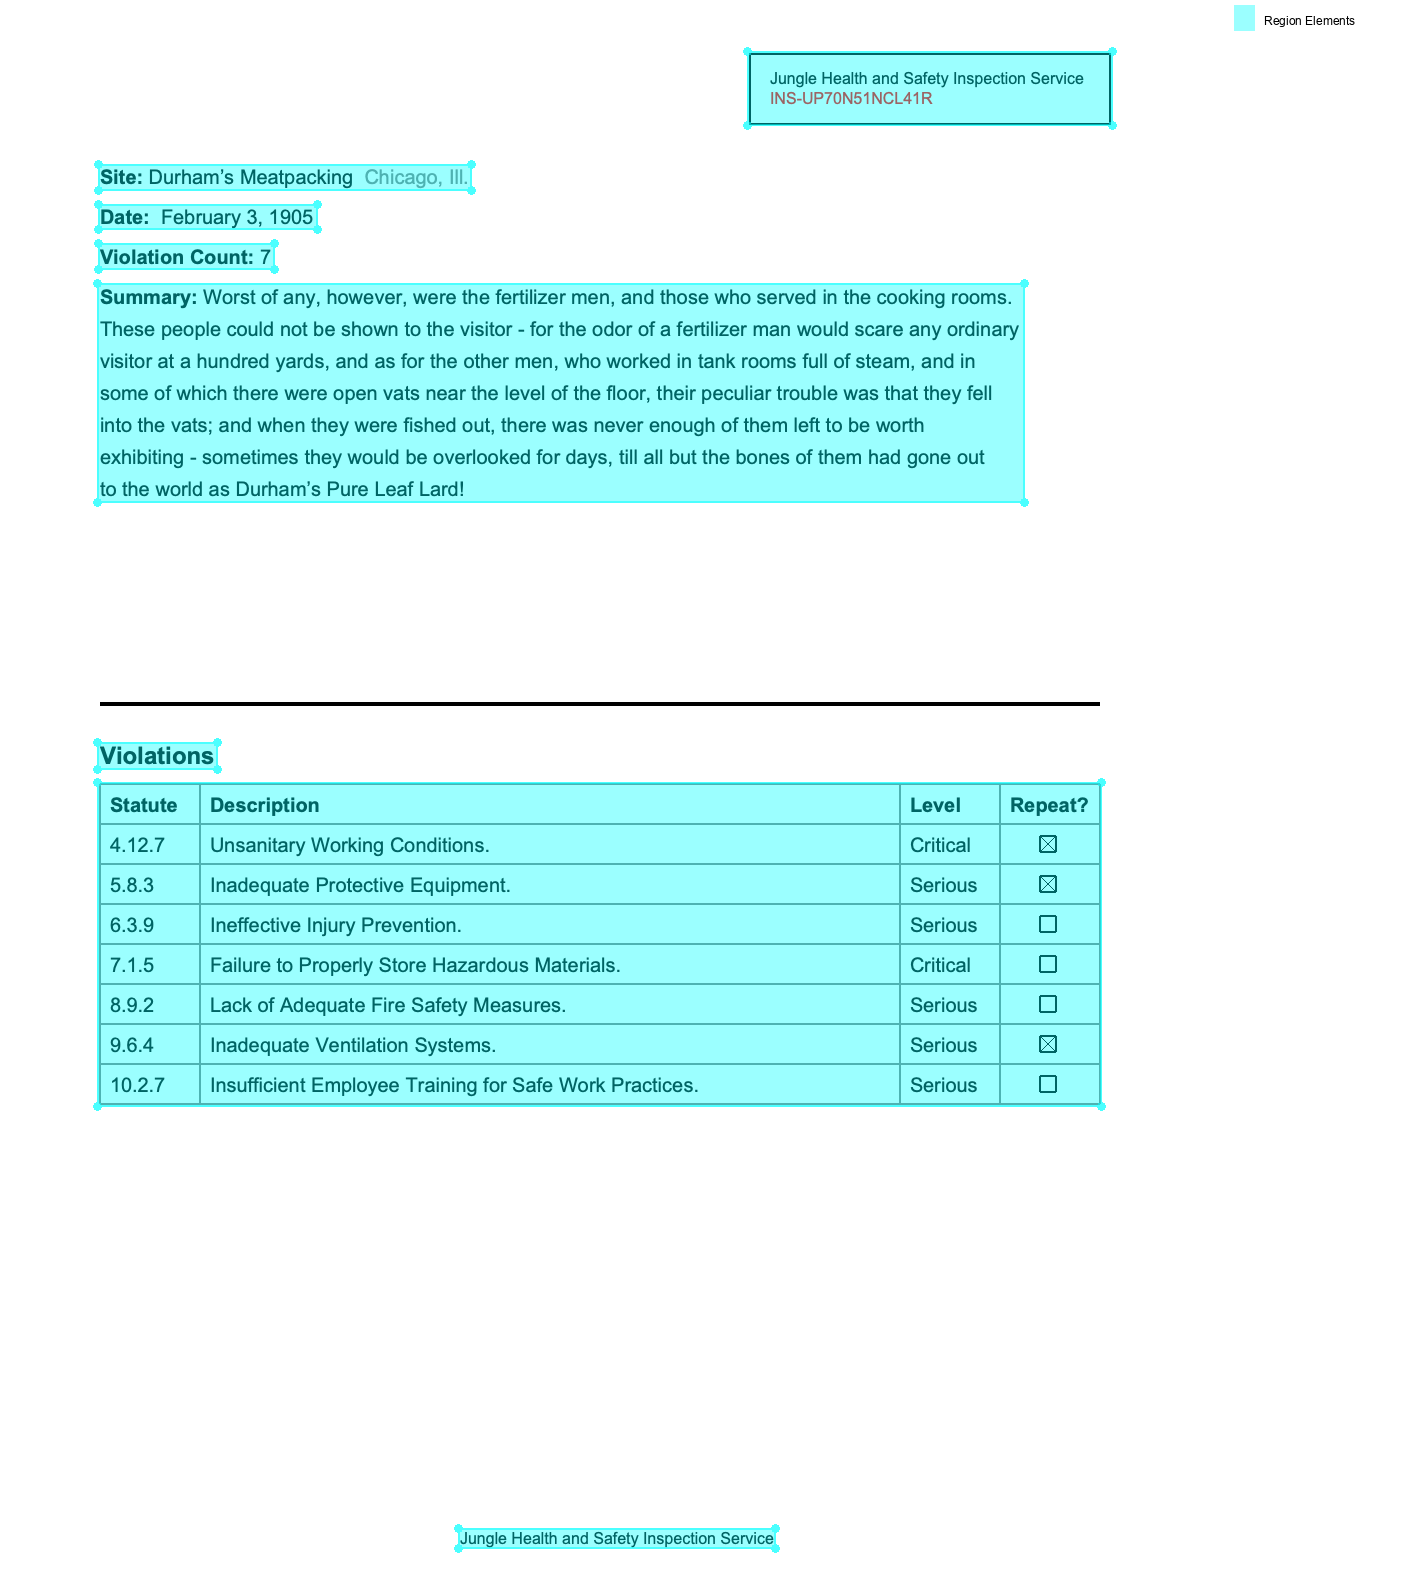

In [5]:
# Highlight all detected regions, colored by type
regions.highlight(
    group_by='type', # Color-code based on the 'type' attribute
).show(
    legend_position='right' # Show a legend for the colors
)

## Finding Specific Region Types

Use attribute selectors to find regions of a specific type.

In [6]:
# Find all detected titles
titles = page.find_all('region[type=title]')
titles

<ElementCollection[Region](count=2)>

In [7]:
# Highlight just the titles
if titles:
    page.highlight_all(titles, color="blue", label="Title").show()

AttributeError: 'Page' object has no attribute 'highlight_all'

In [ ]:
# Find all detected tables
tables = page.find_all('region[type=table]')
tables

In [ ]:
# Highlight just the tables
if tables:
    page.highlight_all(tables, color="green", label="Table").show()

In [ ]:
# Find plain text regions
paragraphs = page.find_all('region[type=plain-text]')
paragraphs

In [ ]:
# Highlight plain text regions
if paragraphs:
    page.highlight_all(paragraphs, color="orange", label="Plain Text", alpha=0.3).show()

## Working with Layout Regions

Detected regions are like any other `Region` object. You can extract text, find elements within them, etc.

In [ ]:
# Get the first detected table region
if tables:
    table_region = tables[0]

    # Extract text from the table region
    table_region.extract_text(layout=True) # Use layout=True for better table formatting

In [ ]:
# Extract the table structure using the region
if tables:
    table_region.extract_table()

In [ ]:
# Find all text elements *inside* the first title region
if titles:
    title_region = titles[0]
    text_in_title = title_region.find_all('text')
    text_in_title.highlight().show()

## Using Different Layout Models

Natural PDF supports multiple engines (`yolo`, `paddle`, `tatr`). Specify the engine when calling `analyze_layout`.

*Note: Using different engines requires installing the corresponding extras (e.g., `natural-pdf[layout_paddle]`).* `yolo` is the default.

In [ ]:
# Analyze using PaddleOCR (if installed)
try:
    page.analyze_layout(engine="paddle")
    paddle_regions = page.find_all('region[model=paddle]')
    f"Found {len(paddle_regions)} regions using PaddleOCR."
except Exception as e:
    f"Paddle engine not available or failed: {e}"

In [ ]:
# Highlight regions detected by Paddle, colored by type
if 'paddle_regions' in locals() and paddle_regions:
    page.highlight_all(paddle_regions, group_by='type', label_attribute='type').show()

In [ ]:
# Analyze using Table Transformer (TATR) - specialized for tables
try:
    page.analyze_layout(engine="tatr")
    tatr_regions = page.find_all('region[model=tatr]')
    f"Found {len(tatr_regions)} regions using TATR."
except Exception as e:
    f"TATR engine not available or failed: {e}"


In [ ]:
# Highlight TATR regions (table, row, column, header), colored by type
if 'tatr_regions' in locals() and tatr_regions:
    page.highlight_all(tatr_regions, group_by='type', label_attribute='type', alpha=0.2).show()

*Note: Calling `analyze_layout` multiple times (even with the same engine) can add duplicate regions. You might want to use `page.clear_regions()` first, or filter by model using `region[model=yolo]`.* 

## Controlling Confidence Threshold

Filter detections by their confidence score.

In [ ]:
# Re-run YOLO analysis (clearing previous results might be good practice)
page.clear_regions()
page.analyze_layout(engine="yolo")

# Find only high-confidence regions (e.g., >= 0.8)
high_conf_regions = page.find_all('region[confidence>=0.8]')
len(high_conf_regions)

In [ ]:
# Highlight only high-confidence regions
if high_conf_regions:
    page.highlight_all(high_conf_regions, color="darkgreen", label=">80% Conf").show()

In [ ]:
# You can also set the threshold during analysis
page.clear_regions()
page.analyze_layout(engine="yolo", confidence=0.8) # Only add regions >= 0.8 confidence
len(page.find_all('region'))

## Table Structure with TATR

The TATR engine provides detailed table structure elements (`table`, `table-row`, `table-column`, `table-column-header`). This is very useful for precise table extraction.

In [ ]:
# Ensure TATR analysis has been run
try:
    page.clear_regions() # Start fresh for clarity
    page.analyze_layout(engine="tatr")
    "TATR analysis complete."
except Exception as e:
    f"TATR engine not available or failed: {e}"

In [ ]:
# Find different structural elements from TATR
tables = page.find_all('region[type=table][model=tatr]')
rows = page.find_all('region[type=table-row][model=tatr]')
cols = page.find_all('region[type=table-column][model=tatr]')
hdrs = page.find_all('region[type=table-column-header][model=tatr]')

f"Found: {len(tables)} tables, {len(rows)} rows, {len(cols)} columns, {len(hdrs)} headers (from TATR)"

In [ ]:
# Visualize the detailed structure
img = page.copy() # Work on a copy
if tables: img.highlight_all(tables, color=(0, 0, 1, 0.1), label="Table")
if rows: img.highlight_all(rows, color=(1, 0, 0, 0.1), label="Row")
if cols: img.highlight_all(cols, color=(0, 1, 0, 0.1), label="Column")
if hdrs: img.highlight_all(hdrs, color=(1, 0, 1, 0.2), label="Header")

img.show()

### Enhanced Table Extraction with TATR

When a `region[type=table]` comes from the TATR model, `extract_table()` can use the underlying row/column structure for more robust extraction.

In [ ]:
# Find the TATR table region again
tatr_table = page.find('region[type=table][model=tatr]')

if tatr_table:
    # This extraction uses the detected rows/columns
    tatr_table.extract_table()
else:
    "TATR table region not found."

## OCR + Layout Analysis

For scanned documents, combine OCR with layout analysis.

In [ ]:
# Example with a scanned PDF (if available)
# pdf_scanned_path = Path("../path/to/scanned.pdf")
# if pdf_scanned_path.exists():
#     pdf_scan = PDF(pdf_scanned_path, ocr=True) # Enable OCR on load
#     scan_page = pdf_scan.pages[0]
#     scan_page.apply_ocr() # Run OCR explicitly if not done on load
#     scan_page.analyze_layout() # Now run layout analysis
#     scan_page.highlight_all(scan_page.find_all('region'), group_by='type').show()
# else:
#     "Scanned PDF example skipped."

"Example for scanned PDFs commented out."

## Next Steps

Layout analysis provides regions that you can use for:

- [Table Extraction](../tables/index.md): Especially powerful with TATR regions.
- [Text Extraction](../text-extraction/index.md): Extract text only from specific region types (e.g., paragraphs).
- [Section Extraction](../section-extraction/index.md): Use detected titles/headings to divide the document.
- [Document QA](../document-qa/index.md): Focus question answering on specific detected regions.